In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps

In [5]:
sql = '''
SELECT
  pct,
  pract.name,
  presc.practice,
  AVG(total_list_size) AS list_size,
  presc.month,
  SUM(IF(form_route='powderinhalation.inhalation',
      items,
      0)) AS dpi,
      SUM(IF(form_route='pressurizedinhalation.inhalation',
      items,
      0)) AS mdi,
      SUM(items) AS totalinhalers,
    SUM(actual_cost) AS totalcost
   FROM
  ebmdatalab.hscic.normalised_prescribing_standard AS presc
LEFT JOIN
  ebmdatalab.hscic.practices AS pract
ON
  presc.practice=pract.code
  AND pract.setting=4
LEFT JOIN  # is this join in the right place
  ebmdatalab.hscic.practice_statistics_all_years AS stat
ON
  presc.practice = stat.practice
  AND presc.month = stat.month
LEFT JOIN
  ebmdatalab.dmd.form_dose AS dmd
ON
  presc.bnf_code=dmd.bnf_code
WHERE
  presc.bnf_code LIKE "030%"
AND (form_route="powderinhalation.inhalation"
    OR form_route= "pressurizedinhalation.inhalation")
GROUP BY
  pct,
  name,
  practice,  
  month
  '''


df_inhaler = bq.cached_read(sql, csv_path='df_inhaler.csv', use_cache=True)  # add `use_cache=False` to override
df_inhaler['month'] = df_inhaler['month'].astype('datetime64[ns]')
df_inhaler.head()

,pct,name,practice,list_size,month,dpi,mdi,totalinhalers,totalcost
0,05J,THE DOW SURGERY,M81020,11255.0,2015-08-01,363,660,1023,28819.91
1,04R,ARTHUR MEDICAL CENTRE,C81017,8303.0,2015-08-01,271,602,873,14914.27
2,00T,THE ALASTAIR ROSS MEDICAL PRACTICE,P82018,6772.0,2015-08-01,245,435,680,18084.27
3,06N,PARKFIELD MEDICAL CENTRE,E82027,12443.0,2015-08-01,226,313,539,19913.55
4,09Y,STANWELL ROAD SURGERY,H81104,6970.0,2015-08-01,177,178,355,10690.03


In [7]:
df_inhaler["df_inhaler"] = 100*(df_inhaler.dpi/(df_inhaler.dpi+df_inhaler.mdi)).fillna(0)

df_inhaler.head()

,pct,name,practice,list_size,month,dpi,mdi,totalinhalers,totalcost,df_inhaler
0,05J,THE DOW SURGERY,M81020,11255.0,2015-08-01,363,660,1023,28819.91,35.483871
1,04R,ARTHUR MEDICAL CENTRE,C81017,8303.0,2015-08-01,271,602,873,14914.27,31.042383
2,00T,THE ALASTAIR ROSS MEDICAL PRACTICE,P82018,6772.0,2015-08-01,245,435,680,18084.27,36.029412
3,06N,PARKFIELD MEDICAL CENTRE,E82027,12443.0,2015-08-01,226,313,539,19913.55,41.929499
4,09Y,STANWELL ROAD SURGERY,H81104,6970.0,2015-08-01,177,178,355,10690.03,49.859155


## Trend of prescribing

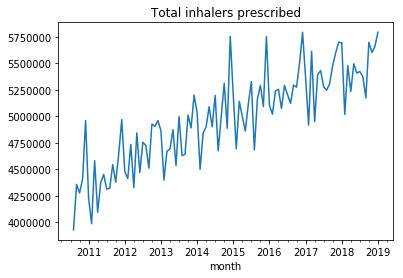

In [8]:
df_inhaler.groupby("month")['totalinhalers'].sum().plot(kind='line', title="Total inhalers prescribed")

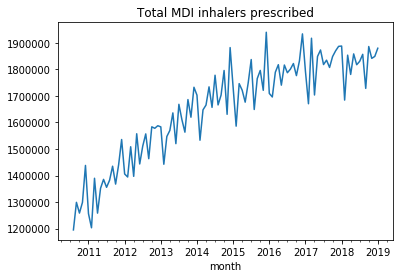

In [9]:
df_inhaler.groupby("month")['dpi'].sum().plot(kind='line', title="Total MDI inhalers prescribed")

In [13]:
latest_df_inhaler = df_inhaler.loc[df_inhaler['month'] == '2018-12-01']
plt = maps.ccg_map(latest_df_inhaler, title="total DPI as proprotion of all inhalers", column='per_dpi', separate_london=True)
plt.show()

KeyError: 'name'